In [1]:
import os
# This can make the kernel die if it doesn't go well
os.environ['R_HOME'] = "C:\Program Files\R\R-4.1.0"
from rpy2.robjects.packages import importr
r_utils = importr('utils')

In [2]:
# r_utils.install_packages('coda')

In [3]:
r_coda = importr('coda')

In [5]:
import pandas as pd

import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()

r_coda = importr('coda')
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
from scipy.special import expit

In [6]:
pd.set_option('display.max_colwidth', -1)

C:\Users\zkirsan\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [7]:
import nltk
#nltk.download('stopwords')

In [8]:
import re
from matplotlib import gridspec
import math
from sklearn.metrics import accuracy_score

### Part 1: Elon Musk's Tweets

In the first part of this project, we will be working with text from the @elonmusk Twitter account. This consists of all tweets from the account from 1/6/2020 to 1/6/2020. The goal is to use Latent Dirichlet Allocation in order to model the topics tweeted from Elon Musk.


In [78]:
df_tweets_orig = pd.read_csv('data/tweets_data (2).csv')

In [79]:
df_tweets = df_tweets_orig.copy()

In [81]:
df_tweets.head(10)

,date,text,preprocessed_text,tokenized_text,like_count,quote_count,reply_count,retweet_count
0,2020-06-18,{{RT @SpaceX: More than 100 spacecraft have been signed up to fly on Falcon 9 since we launched the rideshare program. Small satellite operat…}},{{rt @spacex: 100 spacecraft signed fly falcon 9 launched rideshare program. small satellite operat…}},"['rt', 'spacex', 'spacecraft', 'signed', 'fly', 'falcon', 'launched', 'rideshare', 'program', 'small', 'satellite', 'operat']",0,0,0,1794
1,2020-06-19,{{Juneteenth is henceforth considered a US holiday at Tesla &amp; SpaceX}},{{juneteenth henceforth considered holiday tesla spacex}},"['juneteenth', 'henceforth', 'considered', 'holiday', 'tesla', 'spacex']",402576,2590,5885,31266
2,2020-06-21,"{{2019 seems so quaint &amp; long ago https://t.co/xfdfcbr0DS, That is our purpose, Tesla Bioweapon Defense Mode\nhttps://t.co/48s5D3ZQO0, We must pass The Great Filter, Mars is my souldog, If heat death is the end of the universe, it really is all about the journey, RT @cleantechnica: Exclusive Pro Photos: Tesla Cybertruck At The Petersen Auto Museum https://t.co/3ixBOsRTst, RT @Tesla: https://t.co/26o1bAP14v}}","{{2019 seems quaint long ago purpose, tesla bioweapon defense mode must pass great filter, mars souldog, heat death end universe, really journey, @cleantechnica: exclusive pro photos: tesla cybertruck petersen auto museum @tesla:","['seems', 'quaint', 'long', 'ago', 'purpose', 'tesla', 'bioweapon', 'defense', 'mode', 'must', 'pass', 'great', 'filter', 'mars', 'souldog', 'heat', 'death', 'end', 'universe', 'really', 'journey', 'cleantechnica', 'exclusive', 'pro', 'photos', 'tesla', 'cybertruck', 'petersen', 'auto', 'museum', 'tesla']",735164,4879,17987,57393
3,2020-06-22,"{{Tentative date for Tesla Shareholder Meeting &amp; Battery Day is Sept 15. Will include tour of cell production system., Reminder that Tesla Full Self-Driving (FSD) price goes up by $1k on July 1st, Enabling basic Tesla Autopilot via Tesla in-app purchase is reduced to $2k until July 1}}","{{tentative date tesla shareholder meeting battery day sept 15. include tour cell production system., reminder tesla full self-driving (fsd) price goes $1k july 1st, enabling basic tesla autopilot tesla in-app purchase reduced $2k july 1}}","['tentative', 'date', 'tesla', 'shareholder', 'meeting', 'battery', 'day', 'sept', 'include', 'tour', 'cell', 'production', 'system', 'reminder', 'tesla', 'full', 'self', 'driving', 'fsd', 'price', 'goes', 'july', 'st', 'enabling', 'basic', 'tesla', 'autopilot', 'tesla', 'in', 'app', 'purchase', 'reduced', 'july']",133435,892,5246,5438
4,2020-06-25,"{{RT @GerberKawasaki: First thoughts driving my new Tesla model Y. Review and discussion of what I learned at Tesla today and outlook for the…, Two Starship tanks in the midbay https://t.co/QJ2V882WOC, Special thanks to Tesla trucking &amp; rail partners for figuratively &amp; literally going the extra mile, Apologies to Tesla customers for shifting delivery dates. It’s a crazy world out there!, RT @cleantechnica: Wall Street Journal: Tesla Model Y Offers “Fierce, Velvety” Driving Characteristics https://t.co/dGY24gCVLz}}","{{rt @gerberkawasaki: first thoughts driving new tesla model y. review discussion learned tesla today outlook the…, two starship tanks midbay special thanks tesla trucking rail partners figuratively literally going extra mile, apologies tesla customers shifting delivery dates. it’s crazy world there!, @cleantechnica: wall street journal: tesla model offers “fierce, velvety” driving characteristics","['rt', 'gerberkawasaki', 'first', 'thoughts', 'driving', 'new', 'tesla', 'model', 'review', 'discussion', 'learned', 'tesla', 'today', 'outlook', 'the', 'two', 'starship', 'tanks', 'midbay', 'special', 'thanks', 'tesla', 'trucking', 'rail', 'partners', 'figuratively', 'literally', 'going', 'extra', 'mile', 'apologies', 'tesla', 'customers', 'shifting', 'delivery', 'dates', 'it', 'crazy', 'world', 'there', 'cleantechnica', 'wall',

**Find the optimal number of topics using the `u_mass` coherence measure. Plot the results; suggest the number of topics in the text.**

Latent Dirichlet Allocation is a probabilistic transformation from bag-of-words counts into a topic space of lower dimensionality. Tweets are seen as a distribution of topics. Topics, in turn, are represented by a distribution of all words in the vocabulary. But we do not know the number of topics that are present in the corpus and the tweets that belong to each topic. With LDA we want to treat the assignment of the tweets to topics as a random variable itself which is estimated from the data at hand. 

In [83]:
# we build a dictionary where for each document, each word has its own id.
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

In [84]:
print("We have {} tweets and {} words in the dictionary.".format(df_tweets_clean.shape[0],len(tweets_dictionary)))

We have 285 tweets and 2360 words in the dictionary.


In [85]:
# We now build the corpus i.e. vectors with the number of occurence of each word per tweet.
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]

Finding the right number of topics for LDA is an art. Topic Coherence technique is usually prefered to Perplexity techniques. With coherence, we quantify the coherence of a topic by measuring the degree of semantic similarity between its high scoring words. This leads to topics which are more human interpretable. The technique selects the top frequently occurring words in each topic. It then computes and aggregates all pairwise scores (UMass) for each of the words to calculate the coherence score for a particular topic.

In [86]:
tweets_coherence = []
for nb_topics in range(1,36):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)
    print(nb_topics,coh)

1 -3.935090071562777
2 -5.436646578043291
3 -5.102586591926506
4 -7.040521221778547
5 -7.3966097543622755
6 -7.632501751115522
7 -8.862186827069078
8 -8.259973866084026
9 -8.172652424332734
10 -11.010593934138111
11 -9.88587254204637
12 -10.025029685925288
13 -10.928025498470406
14 -9.751228956975192
15 -10.092029293909999
16 -10.227474796725932
17 -9.651037671621134
18 -10.077619027349272
19 -10.376516703345855
20 -9.765655331627023
21 -10.119162938488651
22 -11.276194028286973
23 -10.590999312288407
24 -10.965004703895014
25 -9.923172940681514
26 -10.564878587949702
27 -10.185425339862672
28 -10.857890549167621
29 -10.026027837235118
30 -11.082497414852563
31 -10.441923669387647
32 -9.72766337420448
33 -10.108569909791726
34 -10.053393237318803
35 -9.19407427808743


We visualize the average coherence score per topic for a range of models trained with a different number of topics below. The number of topics for which the average score plateaus, is the sweet spot we are looking for. So our best guess for the number of topics is around 22. We should consider that, typically a corpus with very short documents (tweets in our case) tends to be more difficult to apply to coherent models than a corpus with longer documents.

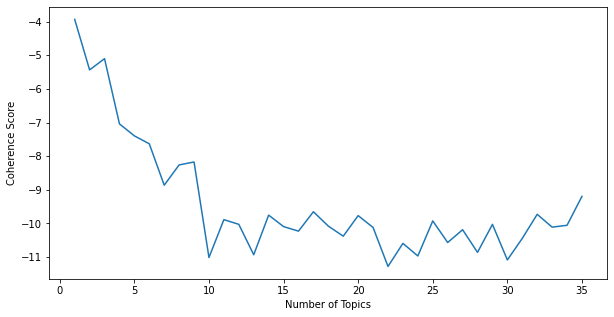

In [87]:
plt.figure(figsize=(10,5))
plt.plot(range(1,36),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

**Run LDA on the texts using the optimal value of $k$ found via the analysis above. Print out the top 10 words and associated betas for each of the $k$ topics. Comment on the results and their plausibility.**

In [88]:
k = 22
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

In [89]:
def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

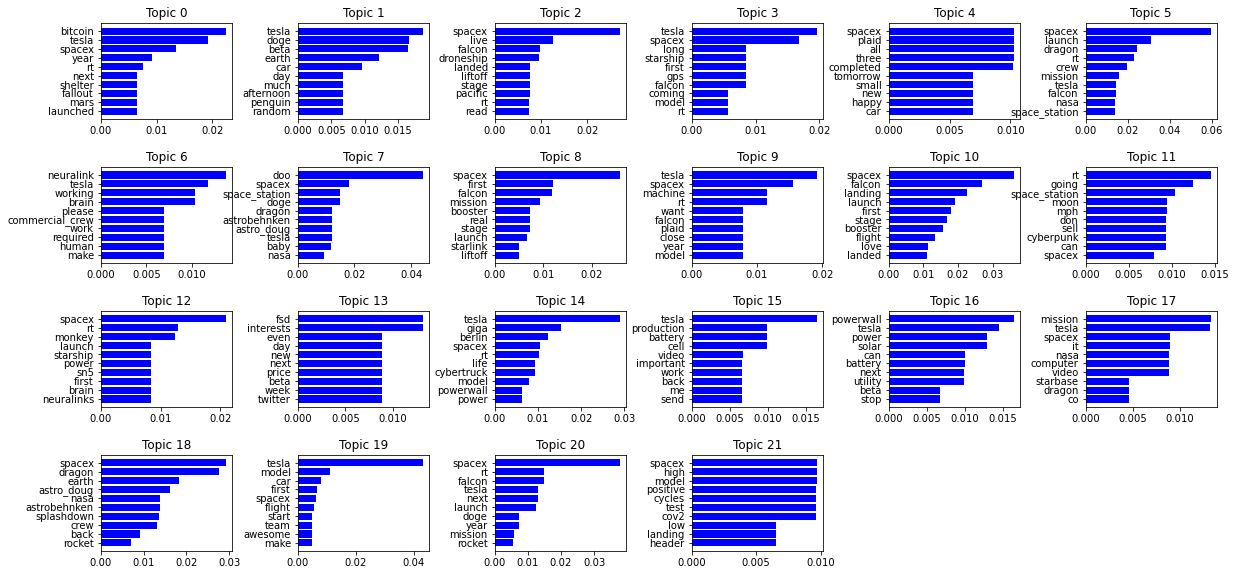

In [90]:
plot_top_words()

The topics do not make totally sense. However we can see the following meaningful match:

Topic 1 - bitcoin

Topic 2, 5 - spaceX

etc